Import the relevant classes and libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.image as mpimg
from datetime import datetime, timedelta
from matplotlib import animation
from IPython.display import HTML

## Variables

Here's where all of your config happens. Change these variables to change how the animation looks and how fast it goes.

This is a list of all of the different places where data can be accessed from. Change the number in `CURRENT_SOURCE` to point to a different location.

In [2]:
NSIDC_0046_FORMAT = "/projects/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.{}-{}.v04.bin"
NSIDC_0046_STAGING_FORMAT = ("/disks/sidads_staging/DATASETS/nsidc0046_weekly_snow_seaice/"
                             "data/EASE2_N25km.snowice.{}-{}.v04.bin")
NSIDC_0046_BROWSE_STAGING_FORMAT = ("/disks/sidads_staging/DATASETS/nsidc0046_weekly_snow_seaice/"
                                    "browse/EASE2_N25km.snowice.{}-{}.v04.png")

SOURCES = [NSIDC_0046_FORMAT, NSIDC_0046_STAGING_FORMAT, NSIDC_0046_BROWSE_STAGING_FORMAT]

CURRENT_SOURCE = SOURCES[2]

This is the start date and end date for the animation. The script will skip over files that don't exist. Make sure that the start date points to a file with that start date- otherwise the script will loop on the wrong days and it won't find any of the correct files.

In [3]:
TIMEFRAME = [datetime(2013, 1, 7), datetime(2014, 6, 23)]

This is the framerate for the animation. `interval` refers to the time between frames, in MS. 50-100 is recommended.

In [4]:
INTERVAL = 50

These parameters refer to the width and height of the rendered animation. Larger animation means longer render times.

In [5]:
ANIMATION_WIDTH = 5
ANIMATION_HEIGHT = 5

Finally, use this variable to toggle log messages. (True/False, case sensitive)

In [6]:
VERBOSE = True

These are some configs and helper methods.

In [7]:
plt.rcParams['animation.writer']= 'avconv'
INDEX = 0
PNG = False

#blatantly copied from http://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
def daterange(timeframe):
    for n in range(int ((timeframe[1] - timeframe[0]).days / 7)):
        yield timeframe[0] + timedelta(n*7)    

def form_smashed_date(date):
    return str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

def form_uri(start_date, end_date):
    return CURRENT_SOURCE.format(form_smashed_date(start_date), form_smashed_date(end_date))

def get_current_datetime(index):
    return DATES_ARRAY[index]

def set_last_dataset(new_dataset):
    global LAST_DATASET
    LAST_DATASET = new_dataset
    
def get_last_dataset():
    return LAST_DATASET
    
def separate_data(data):
    return np.minimum(data, 5)
    
def create_plot(start_date, data, **kwargs):
    if 'title' in kwargs:
        plt.title(kwargs['title'] + " " + str(start_date))
    else:
        plt.title(str(start_date))
    return plt.imshow(separate_data(data), cmap="hot", animated=True)

Rendering PNG
Rendering data for date range 2013-01-07 00:00:00 - 2013-01-13 00:00:00
Rendering data for date range 2013-01-07 00:00:00 - 2013-01-13 00:00:00
Rendering data for date range 2013-01-14 00:00:00 - 2013-01-20 00:00:00
Rendering data for date range 2013-01-21 00:00:00 - 2013-01-27 00:00:00
Rendering data for date range 2013-01-28 00:00:00 - 2013-02-03 00:00:00
Rendering data for date range 2013-02-04 00:00:00 - 2013-02-10 00:00:00
Rendering data for date range 2013-02-11 00:00:00 - 2013-02-17 00:00:00
Rendering data for date range 2013-02-18 00:00:00 - 2013-02-24 00:00:00
Rendering data for date range 2013-02-25 00:00:00 - 2013-03-03 00:00:00
Rendering data for date range 2013-03-04 00:00:00 - 2013-03-10 00:00:00
Rendering data for date range 2013-03-11 00:00:00 - 2013-03-17 00:00:00
Rendering data for date range 2013-03-18 00:00:00 - 2013-03-24 00:00:00
Rendering data for date range 2013-03-25 00:00:00 - 2013-03-31 00:00:00
Rendering data for date range 2013-04-01 00:00:00 

Rendering data for date range 2013-01-07 00:00:00 - 2013-01-13 00:00:00


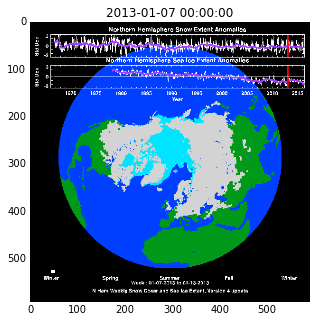

In [8]:
%matplotlib inline

DATES_ARRAY = []

def render(INDEX):
    start_date = get_current_datetime(INDEX)
    end_date = start_date + timedelta(days = 6)
    image = None
    try:
        if PNG:
            read_data = mpimg.imread(form_uri(start_date, end_date))
            image = create_plot(start_date, read_data)
        else:
            with open(form_uri(start_date, end_date), 'rb') as fp:
                read_data = np.fromfile(fp, dtype=np.uint8).reshape(720, 720)
            image = create_plot(start_date, read_data)
        set_last_dataset(read_data)
        if VERBOSE:
            print("Rendering data for date range " + str(start_date) + " - " + str(end_date))
    except FileNotFoundError as e:
        print("----ERROR: No file for " + str(start_date) + "----")
        image = create_plot(start_date, get_last_dataset(), title="FILE MISSING FOR")
    except ValueError as e:
        print("----ERROR: Corrupt file for " + str(start_date) + "----")
        image = create_plot(start_date, get_last_dataset(), title="CORRUPT FILE FOR")
    else:
        INDEX += 1
        return [image]
    
def setup():
    if CURRENT_SOURCE == NSIDC_0046_BROWSE_STAGING_FORMAT:
        global PNG
        PNG = True
        print("Rendering PNG")
    for date in daterange(TIMEFRAME):
        DATES_ARRAY.append(date)
    
setup()

fig = plt.figure(figsize=(ANIMATION_WIDTH, ANIMATION_HEIGHT))
anim = animation.FuncAnimation(fig, render, frames=len(DATES_ARRAY), fargs=INDEX, interval=INTERVAL, repeat=True)
HTML(anim.to_html5_video())